# Defining MLP

In [1]:
import os
os.chdir('/Users/mikolajmroz/Developer/Computational_Intelligence_Methods')
print(os.getcwd())

/Users/mikolajmroz/Developer/Computational_Intelligence_Methods


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [3]:
def sigmoid(x):
    x = np.clip(x, -500, 500)  # Avoid overflow
    return np.where(x > 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

In [4]:
def sigmoid_derivative(x):
    # Corrected sigmoid derivative to properly compute the derivative
    return sigmoid(x) * (1 - sigmoid(x))

In [5]:
def linear(x):
    """Linear activation function: f(x) = x"""
    return x

In [6]:
def linear_derivative(x):
    """Derivative of linear activation function: f'(x) = 1"""
    return 1

In [7]:
def relu(x):
    """ReLU activation function: f(x) = max(0, x)"""
    return np.maximum(0,x)

In [8]:
def relu_derivative(x):
    """Derivative of ReLU activation function: f'(x) = 1 if x > 0 else 0"""
    return np.where(x > 0, 1, 0)

In [9]:
def tanh(x):
    """Tanh activation function: f(x) = tanh(x)"""
    return np.tanh(x)

In [10]:
def tanh_derivative(x):
    """Derivative of tanh activation function: f'(x) = 1 - tanh(x)^2"""
    return 1 - np.tanh(x)**2

In [11]:
def mse(predictions, targets):
    return np.mean((predictions - targets) ** 2)

In [12]:
class MLP:
    """
    Multilayer Perceptron (MLP) Class:
    A simple implementation of a feedforward neural network that uses backpropagation for training.

    Attributes:
    - layer_sizes (list): The sizes of the layers in the neural network.
    - layer_weights (list): Weights for each layer in the neural network, initialized based on He initialization.
    - layer_biases (list): Biases for each layer in the neural network, initialized to zeros.
    """
    
    def __init__(self, sizes, activation_fn=sigmoid,activation_fn_derivative=sigmoid_derivative):
        """
        Initializes a new MLP instance.
        
        Parameters:
        - sizes (list): A list containing the size (number of neurons) of each layer in the network.
        - activation_fn (str): The name of the activation function to use ('sigmoid' by default).
        """
        self.layer_sizes = sizes
        self.activation_fn = activation_fn
        self.layer_weights = [np.random.randn(y, x) * np.sqrt(2. / x) / 10 for x, y in zip(sizes[:-1], sizes[1:])]
        self.layer_biases = [np.zeros((y, 1)) for y in sizes[1:]]
        self.activation_fn_derivative = activation_fn_derivative

    def display_weights_biases(self):
        """Prints the weights and biases of each layer in the network."""
        print("Final Weights and Biases:")
        for layer_index, (weights, biases) in enumerate(zip(self.layer_weights, self.layer_biases)):
            print(f"Layer {layer_index + 1} Weights:\n{weights}")
            print(f"Layer {layer_index + 1} Biases:\n{biases}")

    def cost_derivative(self, output_acts, true_val):
        # Calculate the derivative of the cost function
        return (output_acts - true_val)
    
    def propagate_forward(self, input_activation):
        """
        Performs forward propagation using the current network weights and biases.
        
        Parameters:
        - input_activation (ndarray): The input data to the network.
        
        Returns:
        - The output of the network.
        - A list of activations for each layer including the input.
        """
        activations = [input_activation]  # Store all layer activations starting with the input.
        for biases, weights in zip(self.layer_biases, self.layer_weights):
            input_activation = self.activation_fn(np.dot(weights, input_activation) + biases)
            activations.append(input_activation)
        return activations[-1], activations  # Return final output and all layer activations.

    def backward_propagation(self, input_val, true_val):
        """
        Performs backpropagation, computing the gradient of the loss function with respect to weights and biases.
        
        Parameters:
        - input_val (ndarray): The input data.
        - true_val (ndarray): The true labels or values for the input data.
        
        Returns:
        - Gradients for the network's weights and biases.
        """
        weight_gradients = [np.zeros(weight.shape) for weight in self.layer_weights]
        bias_gradients = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        # Forward pass to get activations and pre-activation values.
        final_act, activations = self.propagate_forward(input_val)
        
        # Calculate error at the output layer.
        error = self.cost_derivative(final_act, true_val) * self.activation_fn_derivative(activations[-1])
        bias_gradients[-1] = error
        weight_gradients[-1] = np.dot(error, activations[-2].T)
        
        # Backpropagate the error to previous layers.
        for l in range(2, len(self.layer_sizes)):
            z = np.dot(self.layer_weights[-l+1].T, error) + self.layer_biases[-l+1]
            error = np.dot(self.layer_weights[-l+1].T, error) * self.activation_fn_derivative(z)
            bias_gradients[-l] = error
            weight_gradients[-l] = np.dot(error, activations[-l-1].T)
        
        return weight_gradients, bias_gradients

    def update_batch(self, batch, learn_rate, regularization, total_size, optimization_method, beta, epsilon=None):
        """
        Updates the weights and biases of the network for a single batch using gradient descent with regularization
        and optionally applies momentum or RMSprop as optimization methods to accelerate convergence.
    
        Parameters:
        - batch (list of tuples): Each tuple contains input data and true labels/values for a batch of samples.
        - learn_rate (float): Learning rate for the optimization.
        - regularization (float): Regularization factor to reduce overfitting by penalizing large weights.
        - total_size (int): Total number of samples in the dataset, used for regularization calculation.
        - optimization_method (str): Specifies the optimization method ('momentum' or 'rmsprop').
        - beta (float): Hyperparameter for the optimization methods, affecting the weighting of past gradients.
        - epsilon (float, optional): A small number to avoid division by zero in 'rmsprop', default is None.
    
        Returns:
        - None, but updates the network's weights and biases in place.
        """
        # Initialize gradients for weights and biases with zeros
        gradient_w = [np.zeros(weight.shape) for weight in self.layer_weights]
        gradient_b = [np.zeros(bias.shape) for bias in self.layer_biases]
        
        # Loop through each data point in the batch
        for input_val, true_val in batch:
            # Perform backpropagation to compute gradients for current data point
            delta_gradient_w, delta_gradient_b = self.backward_propagation(input_val, true_val)
            # Accumulate gradients over the batch
            gradient_w = [w + dw for w, dw in zip(gradient_w, delta_gradient_w)]
            gradient_b = [b + db for b, db in zip(gradient_b, delta_gradient_b)]

        # Apply optimization method if specified
        if optimization_method == 'momentum':
            # Initialize velocity terms for weights and biases if not already initialized
            if not hasattr(self, 'velocity_weights'):
                self.velocity_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.velocity_biases = [np.zeros_like(b) for b in self.layer_biases]
                
            # Update velocities based on gradients and apply to weights and biases
            self.velocity_weights = [beta * vw + (1 - beta) * gw for vw, gw in zip(self.velocity_weights, gradient_w)]
            self.velocity_biases = [beta * vb + (1 - beta) * gb for vb, gb in zip(self.velocity_biases, gradient_b)]
            # Update weights and biases using momentum method
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - learn_rate * vw
                                  for w, vw in zip(self.layer_weights, self.velocity_weights)]
            self.layer_biases = [b - learn_rate * vb for b, vb in zip(self.layer_biases, self.velocity_biases)]
            
        elif optimization_method == 'rmsprop':
            # Initialize squared gradient terms for weights and biases if not already initialized
            if not hasattr(self, 'squared_gradients_weights'):
                self.squared_gradients_weights = [np.zeros_like(w) for w in self.layer_weights]
                self.squared_gradients_biases = [np.zeros_like(b) for b in self.layer_biases]
                
            # Update squared gradients based on new gradients
            self.squared_gradients_weights = [beta * sgw + (1 - beta) * (gw**2)
                                              for sgw, gw in zip(self.squared_gradients_weights, gradient_w)]
            self.squared_gradients_biases = [beta * sgb + (1 - beta) * (gb**2)
                                             for sgb, gb in zip(self.squared_gradients_biases, gradient_b)]
            # Update weights and biases using rmsprop method
            self.layer_weights = [(1 - learn_rate * (regularization / total_size)) * w - 
                                  (learn_rate / (np.sqrt(sgw) + epsilon)) * gw
                                  for w, sgw, gw in zip(self.layer_weights, self.squared_gradients_weights, gradient_w)]
            self.layer_biases = [b - (learn_rate / (np.sqrt(sgb) + epsilon)) * gb
                                 for b, sgb, gb in zip(self.layer_biases, self.squared_gradients_biases, gradient_b)]
    
    def train(self, training_set, epoch_count, learn_rate, batch_size_input, regularization=0.0,
              visual_interval=100, optimization_method='momentum', beta=0.9, epsilon=1e-8, 
              X_val_scaled=None, y_val_scaled=None, X_val=None, y_val=None,
              scaler_X=None, scaler_y=None, mse_limit=None):
        """
        Trains the neural network over a specified number of epochs using mini-batch gradient descent,
        and tracks performance over epochs through mean squared error on a validation set. Supports learning
        rate scheduling, regularization, and early stopping.
    
        Parameters:
        - training_set (list): Training data consisting of tuples of input values and true labels.
        - epoch_count (int): Total number of epochs to train the network.
        - learn_rate (float): Initial learning rate for optimization.
        - batch_size_input (int or float): Size of the mini-batches for training. If float, it represents
          the percentage of the total dataset size.
        - regularization (float): Regularization factor for reducing overfitting.
        - visual_interval (int): Frequency of epochs at which to calculate and print the MSE for tracking.
        - optimization_method (str): Optimization method to use ('momentum' or 'rmsprop').
        - beta (float): Parameter for the optimization method that controls the momentum or the weighted average.
        - epsilon (float): Small value to prevent division by zero in 'rmsprop'.
        - X_val_scaled, y_val_scaled, X_val, y_val (ndarray, optional): Validation datasets for performance evaluation.
        - scaler_X, scaler_y (preprocessing scaler objects, optional): Scalers used for transforming data back to original scale for MSE calculation.
        - mse_limit (float, optional): MSE value at which training can be stopped early for performance.
    
        Returns:
        - mse_history (list): History of mean squared error values at each visual interval.
        """
    
        # Initialize an empty list to store the history of mean squared errors (MSE) for each epoch
        mse_history = []
        # Determine the total number of samples in the training set
        data_size = len(training_set)
        # Store the initial learning rate, which may be adjusted during training
        rate_init = learn_rate
    
        # Determine mini-batch size based on whether the batch_size_input is a percentage or fixed value
        if isinstance(batch_size_input, float):  # If batch_size_input is a float, treat it as a percentage
            mini_batch_size = max(1, min(data_size, int(data_size * batch_size_input / 100)))
        elif isinstance(batch_size_input, int):  # If batch_size_input is an integer, treat it as a fixed size
            mini_batch_size = max(1, min(data_size, batch_size_input))
        else:  # Raise an error if batch_size_input is neither float nor int
            raise ValueError("batch_size_input must be an integer (fixed size) or a float (percentage of dataset)")
    
        # Iterate through each epoch for training
        for epoch in range(epoch_count):
            # Randomly shuffle the training set to ensure randomness of mini-batches
            np.random.shuffle(training_set)
            # Create mini-batches from the training set
            mini_batches = [training_set[k:k + mini_batch_size] for k in range(0, data_size, mini_batch_size)]
            # Update the model's weights and biases for each mini-batch
            for mini_batch in mini_batches:
                self.update_batch(mini_batch, learn_rate, regularization, data_size, optimization_method, beta, epsilon)
    
            # Adjust the learning rate after each epoch (simple learning rate decay)
            learn_rate = rate_init / (1 + 0.01 * epoch)
    
            # At specified intervals or the last epoch, evaluate and print the model's performance
            if epoch % visual_interval == 0 or epoch == epoch_count - 1:
                # Generate predictions for the validation set
                predictions_scaled_mse = np.array(
                    [self.propagate_forward(x.reshape(-1, 1))[0] for x in X_val_scaled])
    
                # Inverse transform the scaled predictions back to their original scale
                predictions_mse = scaler_y.inverse_transform(predictions_scaled_mse.reshape(-1, 1))
    
                # Calculate the mean squared error on the validation set
                current_mse = mse(predictions_mse, y_val)
                # Append the MSE to the history for tracking
                mse_history.append((epoch, current_mse))
                # Print the current epoch and its MSE
                print(f'Epoch {epoch}, MSE: {current_mse}')
    
                # If a threshold for MSE is set and the current MSE is below this threshold, stop training
                if mse_limit is not None and current_mse < mse_limit:
                    break
    
        # Return the history of MSE values
        return mse_history
    
    def visualize_network(self):
        fig, ax = plt.subplots()
    
        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))
    
            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.layer_weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)
                        # Add weight value on the line
                        ax.text(i + 0.5, (j + k) / 2, f'{weight:.2f}', color=color, ha='center')
    
            # Add bias values next to the nodes
            for j in range(self.layer_sizes[i]):
                if j < len(self.layer_biases[i]):
                    ax.text(i, j, f'b={self.layer_biases[i][j, 0]:.2f}', color='blue', ha='right')
    
        plt.show()
        
    def visualize_network_working(self):
        fig, ax = plt.subplots()

        # For each layer
        for i in range(len(self.layer_sizes)):
            # Draw the nodes of the layer
            ax.scatter([i]*self.layer_sizes[i], range(self.layer_sizes[i]))

            # Draw the weights connecting the nodes of the current layer to the next layer
            if i < len(self.layer_sizes) - 1:
                for j in range(self.layer_sizes[i]):
                    for k in range(self.layer_sizes[i+1]):
                        weight = self.layer_weights[i][k, j]
                        color = 'g' if weight >= 0 else 'r'
                        ax.plot([i, i+1], [j, k], color=color)

        plt.show()



In [13]:
class DataScaler:
    def __init__(self, method="standardization"):
        self.method = method
        self.min = None
        self.max = None
        self.mean = None
        self.std = None

    def fit_transform(self, data):
        if self.method == "min_max":
            return self.fit_transform_min_max(data)
        elif self.method == "standardization":
            return self.fit_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def transform(self, data):
        if self.method == "min_max":
            return self.transform_min_max(data)
        elif self.method == "standardization":
            return self.transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def inverse_transform(self, data):
        if self.method == "min_max":
            return self.inverse_transform_min_max(data)
        elif self.method == "standardization":
            return self.inverse_transform_standardization(data)
        else:
            raise ValueError("Unsupported scaling method")

    def fit_transform_min_max(self, data):
        self.min = np.min(data, axis=0)
        self.max = np.max(data, axis=0)
        return (data - self.min) / (self.max - self.min)

    def transform_min_max(self, data):
        return (data - self.min) / (self.max - self.min)

    def inverse_transform_min_max(self, data):
        return data * (self.max - self.min) + self.min

    def fit_transform_standardization(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)
        return (data - self.mean) / self.std

    def transform_standardization(self, data):
        return (data - self.mean) / self.std

    def inverse_transform_standardization(self, data):
        return data * self.std + self.mean

In [109]:
def plot_mse(mse_history):
    plt.plot(mse_history)
    plt.title('MSE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error')
    plt.show()

# Loading data

In [110]:
df_train_square_large = pd.read_csv('./data/regression/square-large-training.csv')
df_test_square_large = pd.read_csv('./data/regression/square-large-test.csv')

In [111]:
df_train_steps_large = pd.read_csv('./data/regression/steps-large-training.csv')
df_test_steps_large = pd.read_csv('./data/regression/steps-large-test.csv')

In [112]:
df_train_multimodal_large = pd.read_csv('./data/regression/multimodal-large-training.csv')
df_test_multimodal_large = pd.read_csv('./data/regression/multimodal-large-test.csv')

In [113]:
X_train_square_large = df_train_square_large['x'].values.reshape(-1, 1)
y_train_square_large = df_train_square_large['y'].values.reshape(-1, 1)

In [114]:
X_test_square_large = df_test_square_large['x'].values.reshape(-1, 1)
y_test_square_large = df_test_square_large['y'].values.reshape(-1, 1)

In [115]:
X_train_steps_large = df_train_steps_large['x'].values.reshape(-1, 1)
y_train_steps_large = df_train_steps_large['y'].values.reshape(-1, 1)

In [116]:
X_test_steps_large = df_test_steps_large['x'].values.reshape(-1, 1)
y_test_steps_large = df_test_steps_large['y'].values.reshape(-1, 1)

In [117]:
X_train_multimodal_large = df_train_multimodal_large['x'].values.reshape(-1, 1)
y_train_multimodal_large = df_train_multimodal_large['y'].values.reshape(-1, 1)

In [118]:
X_test_multimodal_large = df_test_multimodal_large['x'].values.reshape(-1, 1)
y_test_multimodal_large = df_test_multimodal_large['y'].values.reshape(-1, 1)

### multimodal-large dataset

In [119]:
# Initialize the scaler for X and y with the desired scaling method
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")

In [120]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_multimodal_large)
y_train_scaled = scaler_y.fit_transform(y_train_multimodal_large)


In [121]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_multimodal_large)
y_test_scaled = scaler_y.transform(y_test_multimodal_large)

In [122]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_multimodal_large, y_train_multimodal_large)]

## 3 warstwy ukryte

In [123]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] )

[array([[ 1.33949519],
       [ 0.4392375 ],
       [-3.58942511],
       [-0.9969535 ],
       [ 0.65708854],
       [-0.26690666],
       [-1.24024053],
       [ 0.35944384],
       [-1.34108748],
       [ 0.62815056],
       [ 0.90888227],
       [ 0.28753358],
       [-0.06189827],
       [-0.26830811],
       [ 0.17121082],
       [ 1.09111152],
       [ 0.7518153 ],
       [ 0.37265455],
       [ 0.75643837],
       [ 1.04419777],
       [-0.01595158],
       [ 0.47251141],
       [-0.41809922],
       [-0.3650972 ],
       [ 1.36728626],
       [-0.76968181],
       [-1.10809372],
       [ 1.5243659 ],
       [ 0.53550284],
       [ 0.51764377],
       [ 0.04482505],
       [ 1.72810144],
       [ 0.73450222],
       [ 0.23284362],
       [ 0.35212935],
       [-0.64933653],
       [ 0.64573504],
       [ 1.622907  ],
       [-1.12403055],
       [-0.42416123],
       [ 0.4101852 ],
       [ 0.73035167],
       [-0.92408259],
       [ 1.50339859],
       [-0.48841322],
       [ 

In [124]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [144]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[ 1.74096067],
       [ 2.1370856 ],
       [-0.55710611],
       [ 0.95215592],
       [ 1.47546427],
       [ 0.4844807 ],
       [-0.54812152],
       [ 0.10189913],
       [-0.08269637],
       [ 0.03516863],
       [ 0.94185157],
       [-1.09474849],
       [ 1.67161272],
       [ 1.27771427],
       [-0.18295103],
       [-0.43740265],
       [ 0.27674921],
       [ 0.81487946],
       [-0.98784018],
       [ 1.30033822],
       [ 0.11158232],
       [-0.87414327],
       [-0.92637137],
       [ 1.21377665],
       [-0.20476764],
       [ 0.23781769],
       [ 0.63542728],
       [ 1.32314902],
       [ 1.06806463],
       [-0.02464292],
       [ 0.99038225],
       [ 1.20904521],
       [ 1.17266081],
       [ 0.2075306 ],
       [-0.15794682],
       [-0.4917527 ],
       [ 0.90192677],
       [ 0.58812344],
       [-0.17930139],
       [-1.76684466],
       [ 1.5076774 ],
       [ 0.4413053 ],
       [ 0.30807067],
       [ 1.31361725],
       [-0.6736753 ],
       [-

In [145]:
mse_sigmoid = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 697.7481038488936
Epoch 10, MSE: 61.309518407737926
Epoch 20, MSE: 25.497163571241806
Epoch 30, MSE: 15.532351947670907
Epoch 40, MSE: 6.6145408144789
Epoch 50, MSE: 15.794289466488873
Epoch 60, MSE: 8.622097024404361
Epoch 70, MSE: 17.545106821911816
Epoch 80, MSE: 27.718427440273814
Epoch 90, MSE: 7.37664819266604
Epoch 100, MSE: 15.95182817572536
Epoch 110, MSE: 30.68650054528282
Epoch 120, MSE: 4.92099178484128
Epoch 130, MSE: 4.144967526293931
Epoch 140, MSE: 5.449866610354083
Epoch 150, MSE: 4.8633740370762615
Epoch 160, MSE: 8.542719383018545
Epoch 170, MSE: 12.24504787049301
Epoch 180, MSE: 12.793744726329725
Epoch 190, MSE: 4.92076583297758
Epoch 200, MSE: 2.1743755014128276
Epoch 210, MSE: 7.389668402296304
Epoch 220, MSE: 2.3846634024288766
Epoch 230, MSE: 2.139153740850264
Epoch 240, MSE: 3.983708678300224
Epoch 250, MSE: 2.220061347214457
Epoch 260, MSE: 3.5581546577088066
Epoch 270, MSE: 2.089559202354919
Epoch 280, MSE: 5.941532384090058
Epoch 290, MSE: 2.2

In [146]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=linear, activation_function_derivative= linear_derivative)

[array([[ 0.3629092 ],
       [-1.33875728],
       [ 0.41958749],
       [-0.68845533],
       [ 0.25246338],
       [-0.01620371],
       [-0.37434497],
       [-0.07259988],
       [ 0.68535319],
       [ 1.5333149 ],
       [-1.03801013],
       [ 0.76104967],
       [-1.33988252],
       [-0.30254788],
       [ 2.17760351],
       [-1.4338981 ],
       [ 0.78215572],
       [ 0.20859995],
       [ 0.29074072],
       [ 1.55514626],
       [-0.3281972 ],
       [ 0.39288461],
       [ 1.1020287 ],
       [ 0.4636441 ],
       [ 0.1205712 ],
       [-1.23980507],
       [ 0.1385666 ],
       [ 0.59419127],
       [ 1.89613043],
       [ 0.17744486],
       [ 0.32682752],
       [ 0.09522017],
       [-0.66996187],
       [ 0.7613156 ],
       [-0.87393708],
       [-0.02246945],
       [-1.03196116],
       [ 0.68639969],
       [-0.63046879],
       [-2.28521666],
       [ 0.04653972],
       [-0.02012587],
       [ 0.20785288],
       [ 1.4406471 ],
       [-1.36011329],
       [-

In [147]:
mse_linear = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 4505.456174450471
Epoch 10, MSE: 4456.907747418768
Epoch 20, MSE: 4727.752045117667
Epoch 30, MSE: 4575.408478532733
Epoch 40, MSE: 4436.495206698132
Epoch 50, MSE: 5609.811577651828
Epoch 60, MSE: 4476.238804616722
Epoch 70, MSE: 4482.540420734381
Epoch 80, MSE: 4508.145200318277
Epoch 90, MSE: 9413.071003796867
Epoch 100, MSE: 4586.186854590115
Epoch 110, MSE: 4464.355359266975
Epoch 120, MSE: 4444.612536897266
Epoch 130, MSE: 4440.505301949108
Epoch 140, MSE: 4717.658620198319
Epoch 150, MSE: 4443.568311785323
Epoch 160, MSE: 4684.71534304488
Epoch 170, MSE: 4452.114305076105
Epoch 180, MSE: 4454.141668987131
Epoch 190, MSE: 4445.2813388878185
Epoch 200, MSE: 4448.788975317899
Epoch 210, MSE: 4456.618077032263
Epoch 220, MSE: 4439.820111901949
Epoch 230, MSE: 4455.695932053913
Epoch 240, MSE: 4462.284534144784
Epoch 250, MSE: 4476.2359775708965
Epoch 260, MSE: 4437.547504045376
Epoch 270, MSE: 4452.877664943935
Epoch 280, MSE: 4534.066867929301
Epoch 290, MSE: 4523.214

In [148]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=tanh, activation_function_derivative= tanh_derivative)

[array([[-0.15864558],
       [-0.20199984],
       [-2.15502306],
       [-0.995567  ],
       [ 1.42202937],
       [-0.21961011],
       [-1.16120596],
       [-0.73136535],
       [ 0.86970836],
       [ 0.47198979],
       [ 1.04467145],
       [-0.82306146],
       [-0.35068155],
       [ 1.93409668],
       [ 0.59868165],
       [-2.15995636],
       [ 0.37789997],
       [-2.24124725],
       [-0.7475897 ],
       [ 0.10547575],
       [-0.13045118],
       [ 0.48977171],
       [ 2.41739906],
       [-0.33244198],
       [ 0.38118349],
       [-1.67211779],
       [ 0.99513566],
       [-0.17444906],
       [-0.0062028 ],
       [ 1.10990273],
       [ 3.71803142],
       [ 1.24031039],
       [-1.42885783],
       [-1.24693872],
       [ 0.45712388],
       [ 0.74966814],
       [-0.73130852],
       [-1.0962913 ],
       [-0.73344381],
       [-0.15764568],
       [ 0.96279268],
       [ 1.52070026],
       [ 1.9098689 ],
       [-1.02379742],
       [-0.51981667],
       [-

In [149]:
mse_tanh = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 687.0090402285766
Epoch 10, MSE: 95.41109201030014
Epoch 20, MSE: 53.903477341727374
Epoch 30, MSE: 40.20617850100821
Epoch 40, MSE: 71.14048113186904
Epoch 50, MSE: 21.228974321601793
Epoch 60, MSE: 25.301730547700284
Epoch 70, MSE: 23.88750222795583
Epoch 80, MSE: 13.920441003653533
Epoch 90, MSE: 12.503714341011994
Epoch 100, MSE: 23.309711513342464
Epoch 110, MSE: 14.117720135263356
Epoch 120, MSE: 9.852222599282436
Epoch 130, MSE: 26.569335166040645
Epoch 140, MSE: 16.404146598601045
Epoch 150, MSE: 7.830648057390085
Epoch 160, MSE: 8.87457690026954
Epoch 170, MSE: 20.126703185644665
Epoch 180, MSE: 15.297240395655418
Epoch 190, MSE: 11.420963551983034
Epoch 200, MSE: 13.778112169038911
Epoch 210, MSE: 10.570114249023634
Epoch 220, MSE: 10.113814365944547
Epoch 230, MSE: 6.956666576209153
Epoch 240, MSE: 18.577165509620123
Epoch 250, MSE: 7.383260738201718
Epoch 260, MSE: 6.865051425959926
Epoch 270, MSE: 7.8304896089897875
Epoch 280, MSE: 5.892496543246406
Epoch 290

In [183]:
mlp_square_1_5 = MLP([1, 64, 32, 32, 1] , activation_function=relu, activation_function_derivative= relu_derivative)

[array([[ 5.22493334e-01],
       [-7.12687681e-01],
       [-3.58026120e-01],
       [-1.16053492e+00],
       [ 4.22677091e-01],
       [-6.34412213e-01],
       [ 1.41061015e-01],
       [-6.27981208e-01],
       [-4.92989668e-01],
       [-1.49912023e+00],
       [ 2.46680869e-01],
       [ 1.26113930e+00],
       [-1.00684586e-01],
       [ 1.32959286e-01],
       [ 1.44370821e+00],
       [ 1.29649487e+00],
       [ 1.03590129e+00],
       [ 1.02702549e+00],
       [-1.32648474e-01],
       [ 2.28878817e-02],
       [-4.19992171e-01],
       [ 1.47425040e+00],
       [-1.18436817e-01],
       [ 9.46109628e-01],
       [ 7.36260862e-01],
       [-1.91502414e+00],
       [-1.86702130e+00],
       [-3.80908868e-01],
       [-7.97456730e-01],
       [-1.52776392e-01],
       [ 1.24303075e+00],
       [ 8.47937914e-01],
       [-4.14190739e-02],
       [-1.92605926e+00],
       [-1.64353474e-01],
       [-1.51314107e-01],
       [-3.75683460e-01],
       [-1.17328553e-01],
       [ 7.

In [184]:
mse_relu = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 489.4256389742149
Epoch 10, MSE: 226.55685802887263
Epoch 20, MSE: 78.59445525171701
Epoch 30, MSE: 40.171323668922966
Epoch 40, MSE: 30.98571455992575
Epoch 50, MSE: 43.82896869519367
Epoch 60, MSE: 48.17271359166436
Epoch 70, MSE: 66.48410389470816
Epoch 80, MSE: 37.84941177480605
Epoch 90, MSE: 28.08603137169578
Epoch 100, MSE: 16.592071613677795
Epoch 110, MSE: 16.929372867987272
Epoch 120, MSE: 30.82744660191136
Epoch 130, MSE: 15.272160292996078
Epoch 140, MSE: 34.20557659700712
Epoch 150, MSE: 15.436304846552199
Epoch 160, MSE: 5.15345755816276
Epoch 170, MSE: 7.684555629076393
Epoch 180, MSE: 6.684329719638119
Epoch 190, MSE: 5.059346261362454
Epoch 200, MSE: 12.79482865058632
Epoch 210, MSE: 18.516190554804805
Epoch 220, MSE: 7.203476392273251
Epoch 230, MSE: 10.974545040549922
Epoch 240, MSE: 11.349769079713559
Epoch 250, MSE: 6.515158402594996
Epoch 260, MSE: 5.253545858391979
Epoch 270, MSE: 6.364016850142361
Epoch 280, MSE: 6.434527203241543
Epoch 290, MSE: 1

In [186]:
def list_to_dataframe(lst):
    return pd.DataFrame(lst, columns=['Epoch', 'MSE'])

In [187]:
mse_sigmoid = list_to_dataframe(mse_sigmoid)
mse_linear = list_to_dataframe(mse_linear)
mse_tanh = list_to_dataframe(mse_tanh)
mse_relu = list_to_dataframe(mse_relu)

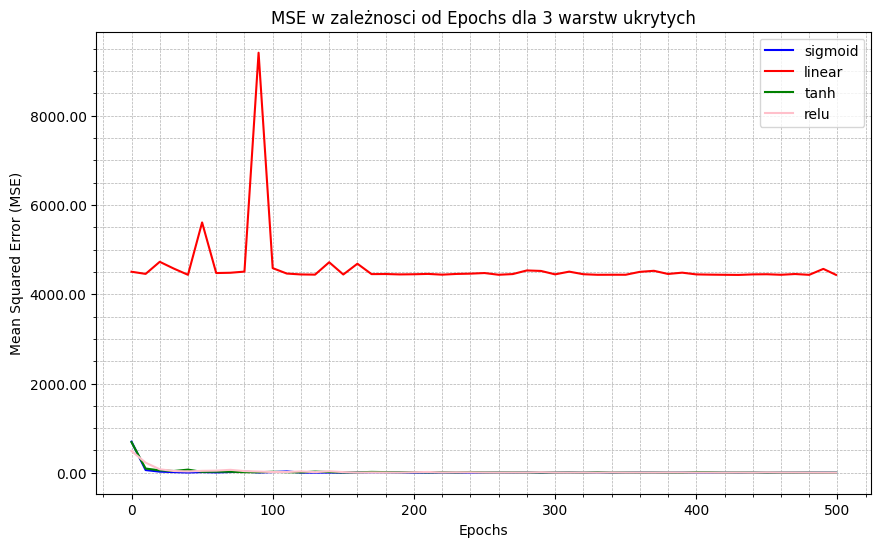

In [191]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla 3 warstw ukrytych')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid, mse_linear, mse_tanh, mse_relu]
labels = ['sigmoid', 'linear', 'tanh', 'relu']
colors = ['blue', 'red', 'green', 'pink']

plot_mse(datasets, labels, colors)


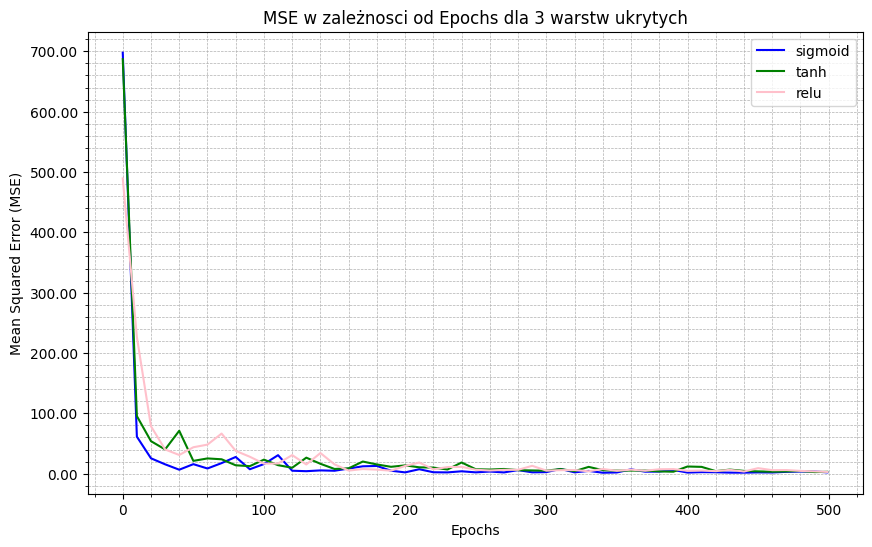

In [192]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_mse(datasets, labels, colors):
    """
    Plots MSE over epochs for given datasets with denser axes.
    
    Parameters:
    - datasets: List of Pandas DataFrames, each containing 'Epoch' and 'MSE' columns.
    - labels: List of labels for the datasets, for the legend.
    - colors: List of colors for the datasets.
    """
    plt.figure(figsize=(10, 6))
    
    ax = plt.gca()  # Get the current Axes instance on the current figure matching the given keyword args, or create one.
    
    for df, label, color in zip(datasets, labels, colors):
        plt.plot(df['Epoch'], df['MSE'], label=label, color=color)
    
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE w zależnosci od Epochs dla 3 warstw ukrytych')
    
    # Set denser x-axis and y-axis
    ax.xaxis.set_major_locator(ticker.AutoLocator())  # Automatically determine the tick locations
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())  # Subdivisions of the major ticks
    ax.yaxis.set_major_locator(ticker.AutoLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    # Optionally, you can format tick labels for readability, e.g., limiting the decimal places for MSE
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    
    plt.legend()
    plt.grid(visible=True, which='both', axis='both', linestyle='--', linewidth=0.5)  # Enhanced grid visibility
    plt.show()

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid, mse_tanh, mse_relu]
labels = ['sigmoid',  'tanh', 'relu']
colors = ['blue', 'green', 'pink']

plot_mse(datasets, labels, colors)


## 2 warstwy ukryte

In [193]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[ 1.06230199],
       [ 0.40243632],
       [ 0.58847208],
       [-0.37287259],
       [-0.1075983 ],
       [-0.84453113],
       [ 0.60300007],
       [ 0.20271232],
       [-0.2035053 ],
       [-1.08446115],
       [-0.82105091],
       [-0.43643498],
       [-1.8820656 ],
       [ 1.75084621],
       [ 0.39531062],
       [-1.77857609],
       [ 0.52328774],
       [ 1.03916045],
       [-1.16258772],
       [ 0.848638  ],
       [-1.11913954],
       [-1.71823794],
       [-0.74567064],
       [-0.21746757],
       [ 0.51548306],
       [-0.33648303],
       [ 1.90887898],
       [-0.21490078],
       [ 1.30422688],
       [-0.6367284 ],
       [-0.35243543],
       [-1.06108959],
       [-0.68788789],
       [-0.49655016],
       [-1.42105977],
       [ 0.49242348],
       [ 0.7076016 ],
       [ 0.63584767],
       [-0.14878931],
       [ 0.79197526],
       [-1.12644995],
       [-0.26580703],
       [-0.05885123],
       [ 0.44786932],
       [-0.69361187],
       [-

In [194]:
mse_sigmoid_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 817.0344237721712
Epoch 10, MSE: 101.84595579622986
Epoch 20, MSE: 88.77969101416666
Epoch 30, MSE: 42.38692669294385
Epoch 40, MSE: 30.42691047823906
Epoch 50, MSE: 10.530484907843224
Epoch 60, MSE: 10.804487542539828
Epoch 70, MSE: 7.982453178213015
Epoch 80, MSE: 31.652220412065304
Epoch 90, MSE: 12.145330358437839
Epoch 100, MSE: 11.087473044610045
Epoch 110, MSE: 22.717153862233623
Epoch 120, MSE: 7.787457979052432
Epoch 130, MSE: 5.265370843670763
Epoch 140, MSE: 18.64312657048835
Epoch 150, MSE: 20.662660311783217
Epoch 160, MSE: 8.021874565694105
Epoch 170, MSE: 11.237043009543727
Epoch 180, MSE: 5.324764744129864
Epoch 190, MSE: 22.136787511096014
Epoch 200, MSE: 13.397377167136511
Epoch 210, MSE: 5.1572223108913855
Epoch 220, MSE: 4.428016780667581
Epoch 230, MSE: 4.367006296033389
Epoch 240, MSE: 4.133302119501959
Epoch 250, MSE: 4.532342861664127
Epoch 260, MSE: 9.675158306661901
Epoch 270, MSE: 8.977973502202047
Epoch 280, MSE: 6.636816620096917
Epoch 290, MS

In [195]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=linear, activation_function_derivative= linear_derivative)

[array([[-0.83037681],
       [-0.07853945],
       [ 1.52075512],
       [ 0.50726921],
       [ 1.60377414],
       [-0.18546883],
       [-0.12641181],
       [ 0.87850121],
       [-0.57968524],
       [-0.80030606],
       [-0.34419939],
       [-0.03282528],
       [-1.93594702],
       [ 1.17079206],
       [-0.13103508],
       [-0.13936149],
       [-0.24492959],
       [ 0.02863056],
       [-1.42801213],
       [-2.22179267],
       [ 2.30933439],
       [-1.27504004],
       [ 0.48507773],
       [ 0.54186388],
       [ 2.76192715],
       [-1.77698043],
       [-1.49101391],
       [ 0.57403237],
       [-0.68377511],
       [-0.07340121],
       [-0.3298099 ],
       [ 0.2270062 ],
       [ 0.94024206],
       [-1.09452438],
       [-0.83763789],
       [-0.80369191],
       [ 0.57965195],
       [ 0.28005805],
       [ 1.45963486],
       [-1.59939984],
       [-0.69776031],
       [ 0.73196262],
       [-0.58615378],
       [ 0.40797779],
       [ 0.0786982 ],
       [ 

In [196]:
mse_linear_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 4625.697115529759
Epoch 10, MSE: 4983.9591635072975
Epoch 20, MSE: 4503.071267065199
Epoch 30, MSE: 4601.582688051345
Epoch 40, MSE: 4437.317012994879
Epoch 50, MSE: 7933.008146468934
Epoch 60, MSE: 4437.106490877899
Epoch 70, MSE: 4464.840478461275
Epoch 80, MSE: 4569.781736777801
Epoch 90, MSE: 4443.946035786923
Epoch 100, MSE: 4450.840053557733
Epoch 110, MSE: 4594.745157135386
Epoch 120, MSE: 4434.521401464187
Epoch 130, MSE: 4462.2557955596385
Epoch 140, MSE: 4599.282929095678
Epoch 150, MSE: 4464.938791298852
Epoch 160, MSE: 4441.258736377443
Epoch 170, MSE: 4466.405907742301
Epoch 180, MSE: 4564.350663717648
Epoch 190, MSE: 4440.137086491078
Epoch 200, MSE: 4444.394737181492
Epoch 210, MSE: 4442.022689323148
Epoch 220, MSE: 4468.316287396667
Epoch 230, MSE: 4436.722106054393
Epoch 240, MSE: 4502.750594330242
Epoch 250, MSE: 4484.54968043172
Epoch 260, MSE: 4434.7468357668595
Epoch 270, MSE: 4463.7557960817485
Epoch 280, MSE: 4438.780403637401
Epoch 290, MSE: 4436.0

In [197]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=tanh, activation_function_derivative= tanh_derivative)

[array([[ 1.04816976],
       [ 1.56872557],
       [ 0.71353041],
       [-0.28095302],
       [-0.42157192],
       [-0.3179272 ],
       [ 0.73719167],
       [ 0.03629866],
       [ 0.15926415],
       [-1.89352125],
       [-0.56714354],
       [ 0.29315312],
       [ 0.60856268],
       [ 0.31639097],
       [-1.16060622],
       [-0.01250946],
       [ 1.41878191],
       [ 0.50005142],
       [-1.70531781],
       [-1.474806  ],
       [-1.6121216 ],
       [ 0.98666702],
       [ 0.14712006],
       [ 1.73865744],
       [ 0.44056698],
       [ 0.73916563],
       [ 0.17739875],
       [ 0.00583919],
       [-1.86888225],
       [-0.68176389],
       [-1.08453296],
       [-1.00297852],
       [ 1.53169908],
       [ 0.46300397],
       [ 0.40057776],
       [ 0.06612551],
       [-1.37332931],
       [ 0.0557    ],
       [ 0.08598267],
       [ 0.23619155],
       [-0.07374697],
       [-1.15112377],
       [-0.0996089 ],
       [ 0.72791204],
       [ 0.727608  ],
       [ 

In [198]:
mse_tanh_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 170.2177198161223
Epoch 10, MSE: 123.50981381990053
Epoch 20, MSE: 31.46751437822697
Epoch 30, MSE: 107.00489044800351
Epoch 40, MSE: 160.78959368347464
Epoch 50, MSE: 52.6325121329044
Epoch 60, MSE: 30.380067174839805
Epoch 70, MSE: 24.65679823584662
Epoch 80, MSE: 29.43110701261974
Epoch 90, MSE: 45.969340450623754
Epoch 100, MSE: 11.358546507654172
Epoch 110, MSE: 14.546570434229563
Epoch 120, MSE: 31.23179087020354
Epoch 130, MSE: 11.207465453858225
Epoch 140, MSE: 44.80416639538805
Epoch 150, MSE: 22.50689476508891
Epoch 160, MSE: 16.21093444726198
Epoch 170, MSE: 39.97138223440865
Epoch 180, MSE: 20.490967792946226
Epoch 190, MSE: 17.017417197634234
Epoch 200, MSE: 40.68541279000965
Epoch 210, MSE: 14.184385594751054
Epoch 220, MSE: 7.523710280528008
Epoch 230, MSE: 12.301613431682474
Epoch 240, MSE: 11.18163161332246
Epoch 250, MSE: 9.26181493385716
Epoch 260, MSE: 20.164623837132645
Epoch 270, MSE: 23.30588385109641
Epoch 280, MSE: 24.879994060420923
Epoch 290, MS

In [199]:
mlp_square_1_5 = MLP([1, 64, 32, 1] , activation_function=relu, activation_function_derivative= relu_derivative)

[array([[ 0.9033776 ],
       [ 0.3021585 ],
       [-0.59964325],
       [-0.21538771],
       [-0.4689014 ],
       [-1.47097322],
       [ 0.21626706],
       [-1.2670231 ],
       [ 0.62017775],
       [-1.62008177],
       [-1.56657272],
       [ 0.16099266],
       [-0.58342338],
       [ 0.51627753],
       [-0.84371358],
       [-0.02803843],
       [ 0.03600243],
       [-1.25223229],
       [-0.78631845],
       [ 0.19019496],
       [ 0.58621149],
       [-1.12228188],
       [-0.61680573],
       [ 1.8066929 ],
       [ 0.81083575],
       [-0.19791338],
       [ 0.69011612],
       [-0.35951459],
       [-0.50283101],
       [-1.60197476],
       [ 1.17362863],
       [-0.32071655],
       [-1.08594805],
       [ 3.0382606 ],
       [-0.1873415 ],
       [ 1.18913578],
       [ 2.13954244],
       [ 0.94397865],
       [ 0.06796584],
       [-0.82987647],
       [ 0.06451821],
       [-0.54312495],
       [-0.79798451],
       [-1.48274989],
       [ 0.93717177],
       [-

In [200]:
mse_relu_2 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 330.68564839098093
Epoch 10, MSE: 51.430606626737166
Epoch 20, MSE: 82.8057549228655
Epoch 30, MSE: 23.31429335482434
Epoch 40, MSE: 18.304353720158847
Epoch 50, MSE: 32.48713120477113
Epoch 60, MSE: 12.219889726926814
Epoch 70, MSE: 21.745226028810386
Epoch 80, MSE: 14.259306583603172
Epoch 90, MSE: 16.687959194992946
Epoch 100, MSE: 31.74850958312097
Epoch 110, MSE: 21.627810235701222
Epoch 120, MSE: 15.943645247506053
Epoch 130, MSE: 12.29204154692693
Epoch 140, MSE: 11.49910701567726
Epoch 150, MSE: 7.324974626963675
Epoch 160, MSE: 12.122699788404654
Epoch 170, MSE: 10.493324866899181
Epoch 180, MSE: 6.870428152834126
Epoch 190, MSE: 11.80468804675904
Epoch 200, MSE: 8.544863223080334
Epoch 210, MSE: 8.61648690711845
Epoch 220, MSE: 13.496765678007655
Epoch 230, MSE: 14.025436103327255
Epoch 240, MSE: 8.776515866733789
Epoch 250, MSE: 7.583063991662181
Epoch 260, MSE: 14.265813863778455
Epoch 270, MSE: 11.155994466766057
Epoch 280, MSE: 5.664383901338357
Epoch 290, M

In [201]:
mse_sigmoid_2 = list_to_dataframe(mse_sigmoid_2)
mse_linear_2 = list_to_dataframe(mse_linear_2)
mse_tanh_2 = list_to_dataframe(mse_tanh_2)
mse_relu_2 = list_to_dataframe(mse_relu_2)

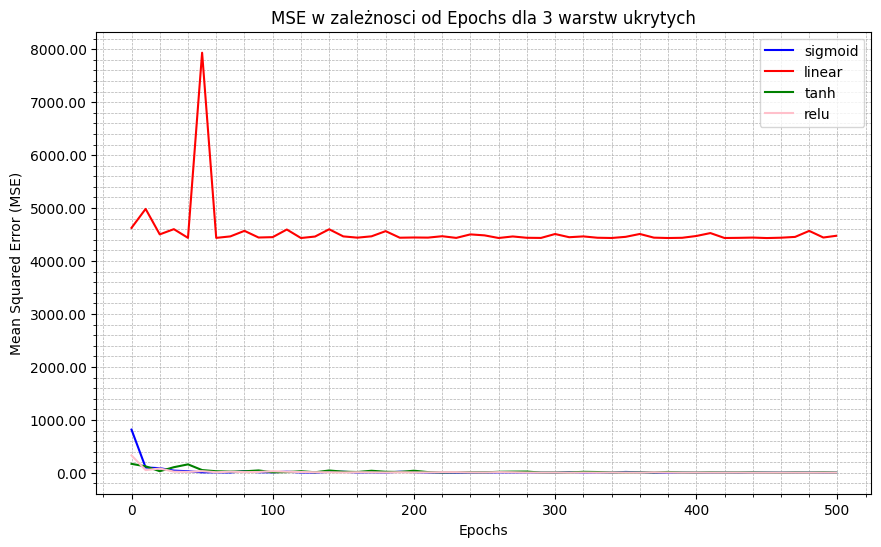

In [202]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_2, mse_linear_2, mse_tanh_2, mse_relu_2]
labels = ['sigmoid', 'linear', 'tanh', 'relu']
colors = ['blue', 'red', 'green', 'pink']

plot_mse(datasets, labels, colors)


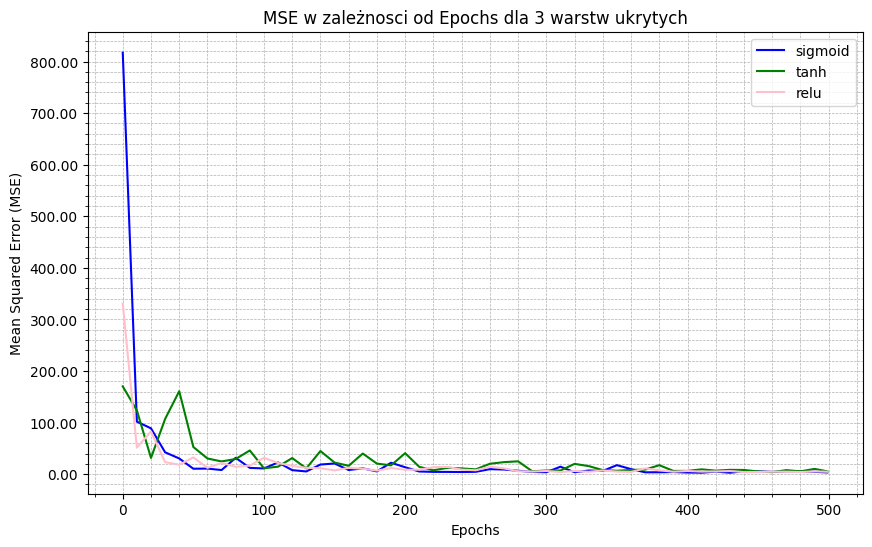

In [203]:

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_2, mse_tanh_2, mse_relu_2]
labels = ['sigmoid',  'tanh', 'relu']
colors = ['blue', 'green', 'pink']

plot_mse(datasets, labels, colors)


## 1 warstwa ukryta

In [204]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)

[array([[-0.42661277],
       [-1.59375725],
       [ 0.07985009],
       [ 0.17263367],
       [-0.70728974],
       [ 0.11004089],
       [ 0.15660256],
       [ 0.50667706],
       [-1.22732901],
       [ 0.25221591],
       [-0.78848339],
       [ 0.67270848],
       [ 1.19527783],
       [-0.44055182],
       [-1.34225453],
       [ 0.86296174],
       [-0.54015538],
       [ 0.3425432 ],
       [-0.12031386],
       [ 0.10814388],
       [ 0.36193681],
       [ 0.30557145],
       [ 0.91692231],
       [ 0.0117854 ],
       [ 0.13615035],
       [ 0.66653605],
       [-1.64317599],
       [-0.84440251],
       [ 0.00626117],
       [ 0.91510641],
       [ 0.30093539],
       [ 1.18307153],
       [-0.294665  ],
       [ 1.88575409],
       [-1.94462222],
       [-1.34663341],
       [ 1.50176655],
       [-0.15038216],
       [ 0.09716466],
       [-0.4385007 ],
       [-0.10044182],
       [-1.09866675],
       [ 0.92962549],
       [ 0.02389611],
       [ 1.21774425],
       [ 

In [205]:
mse_sigmoid_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 2528.4406199245786
Epoch 10, MSE: 788.7734006355025
Epoch 20, MSE: 607.436920886482
Epoch 30, MSE: 1014.9734385175518
Epoch 40, MSE: 628.8778352600981
Epoch 50, MSE: 445.81863128597564
Epoch 60, MSE: 434.7843279049877
Epoch 70, MSE: 335.5883731746712
Epoch 80, MSE: 337.6914512139893
Epoch 90, MSE: 366.4015654292925
Epoch 100, MSE: 345.8104324640364
Epoch 110, MSE: 393.3506853940123
Epoch 120, MSE: 364.3837151863308
Epoch 130, MSE: 363.5494669983825
Epoch 140, MSE: 339.7876001422276
Epoch 150, MSE: 319.05043934591697
Epoch 160, MSE: 321.64716241300937
Epoch 170, MSE: 330.3340494963069
Epoch 180, MSE: 332.2083332582568
Epoch 190, MSE: 408.1491831089769
Epoch 200, MSE: 327.9206912039897
Epoch 210, MSE: 338.29850651806
Epoch 220, MSE: 323.22289658558066
Epoch 230, MSE: 338.9684232958363
Epoch 240, MSE: 319.14287324059603
Epoch 250, MSE: 329.04952178836646
Epoch 260, MSE: 345.97300760884525
Epoch 270, MSE: 338.24081810238397
Epoch 280, MSE: 329.7900364119068
Epoch 290, MSE: 31

In [206]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=linear, activation_function_derivative= linear_derivative)

[array([[ 0.36474503],
       [-1.5696359 ],
       [ 0.0931508 ],
       [-0.48276207],
       [-1.61763356],
       [-1.51329528],
       [-0.59196171],
       [ 1.45817498],
       [-1.56863188],
       [ 1.32801048],
       [ 0.62420081],
       [-1.61792309],
       [-0.3091295 ],
       [ 0.18810947],
       [-0.50302098],
       [-1.15746719],
       [-0.28261999],
       [ 1.11162113],
       [ 3.72653075],
       [-0.21914218],
       [-1.04268392],
       [-0.66356886],
       [ 0.73941202],
       [-0.34260001],
       [ 0.30336741],
       [ 1.14322062],
       [ 1.7196488 ],
       [ 0.46674541],
       [ 0.71840249],
       [-0.66592804],
       [-1.03431837],
       [-0.34390107],
       [ 1.06040803],
       [-0.65087792],
       [ 1.89419899],
       [-1.85842731],
       [-0.16541603],
       [-0.36769896],
       [ 1.79983418],
       [ 0.02667986],
       [ 1.4620475 ],
       [-2.18058827],
       [-1.02008985],
       [ 1.63337406],
       [ 1.46293385],
       [-

In [207]:
mse_linear_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 5006.484482119918
Epoch 10, MSE: 4531.050964580499
Epoch 20, MSE: 5215.478686019272
Epoch 30, MSE: 4683.9149651576
Epoch 40, MSE: 4596.768891318784
Epoch 50, MSE: 4461.442359988082
Epoch 60, MSE: 4806.008168560237
Epoch 70, MSE: 4514.15514661151
Epoch 80, MSE: 4442.3379841655415
Epoch 90, MSE: 4502.873548631559
Epoch 100, MSE: 4585.095972084088
Epoch 110, MSE: 4480.62276713266
Epoch 120, MSE: 4442.510037587308
Epoch 130, MSE: 4439.837913276591
Epoch 140, MSE: 4476.860666835819
Epoch 150, MSE: 4437.910269852089
Epoch 160, MSE: 4517.219023361929
Epoch 170, MSE: 4530.212499690489
Epoch 180, MSE: 4503.105820934743
Epoch 190, MSE: 4484.336983492775
Epoch 200, MSE: 4474.293937071932
Epoch 210, MSE: 4434.437341442423
Epoch 220, MSE: 4434.299174117096
Epoch 230, MSE: 4446.623588900723
Epoch 240, MSE: 4441.843298918299
Epoch 250, MSE: 4439.416038584186
Epoch 260, MSE: 4468.957047004386
Epoch 270, MSE: 4434.582529450035
Epoch 280, MSE: 4498.713136515172
Epoch 290, MSE: 4434.4124790

In [208]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=tanh, activation_function_derivative= tanh_derivative)

[array([[-0.63422421],
       [ 1.02669713],
       [ 0.56983585],
       [-1.20932039],
       [ 0.44605537],
       [ 1.7103442 ],
       [-1.79421207],
       [-1.34895332],
       [-1.74608236],
       [ 0.95500897],
       [-0.97246695],
       [-0.06671395],
       [-0.01807596],
       [ 0.73162708],
       [-1.31026973],
       [-0.19821671],
       [ 0.83733535],
       [ 0.57793199],
       [ 0.15430866],
       [-0.34483559],
       [-0.02965106],
       [-0.35617482],
       [ 0.72060175],
       [ 0.19286206],
       [ 0.6313361 ],
       [ 1.61310354],
       [-0.88780859],
       [ 0.12514288],
       [ 1.46132547],
       [ 0.32321195],
       [-2.19016207],
       [ 0.56342566],
       [-0.40108685],
       [-0.69574679],
       [ 1.39285174],
       [ 2.17190763],
       [ 1.21295874],
       [ 1.99872936],
       [-1.45052233],
       [ 2.52610749],
       [-1.63560118],
       [-0.27343975],
       [-0.23739453],
       [ 0.18116949],
       [-0.35893876],
       [-

In [209]:
mse_tanh_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 880.78451511437
Epoch 10, MSE: 528.2457930667102
Epoch 20, MSE: 330.40835459617125
Epoch 30, MSE: 336.6262895796698
Epoch 40, MSE: 394.2852274986772
Epoch 50, MSE: 301.5208003918749
Epoch 60, MSE: 276.35362468321165
Epoch 70, MSE: 349.27425646426326
Epoch 80, MSE: 272.6010634644287
Epoch 90, MSE: 289.0504593055529
Epoch 100, MSE: 279.6034106899187
Epoch 110, MSE: 370.8904706156678
Epoch 120, MSE: 231.2768214894209
Epoch 130, MSE: 300.26960983891246
Epoch 140, MSE: 238.44534568212356
Epoch 150, MSE: 293.0622203580028
Epoch 160, MSE: 238.19501173312065
Epoch 170, MSE: 209.64299286365662
Epoch 180, MSE: 354.2735248704466
Epoch 190, MSE: 236.96634660177003
Epoch 200, MSE: 231.6324327477243
Epoch 210, MSE: 366.6961474899753
Epoch 220, MSE: 215.2361328358242
Epoch 230, MSE: 214.71655291947675
Epoch 240, MSE: 207.76639224493584
Epoch 250, MSE: 206.39497004184435
Epoch 260, MSE: 203.14504560832498
Epoch 270, MSE: 205.57749566327414
Epoch 280, MSE: 217.97011629302455
Epoch 290, MS

In [210]:
mlp_square_1_5 = MLP([1, 64, 1] , activation_function=relu, activation_function_derivative= relu_derivative)

[array([[-0.88640204],
       [-0.88283464],
       [-0.42143017],
       [ 2.05568043],
       [ 0.24974438],
       [ 0.23448338],
       [-1.46098387],
       [-0.56078689],
       [-0.88784626],
       [-1.7064043 ],
       [-0.19168293],
       [-1.46369072],
       [-1.59896508],
       [-2.65467686],
       [ 0.51534885],
       [ 0.96623797],
       [ 0.58246671],
       [-0.42882417],
       [-0.94699727],
       [ 1.15103885],
       [ 0.95571483],
       [-0.61840552],
       [ 1.36045507],
       [ 1.39550164],
       [-0.63178275],
       [-0.32441189],
       [ 0.90241302],
       [ 0.80389101],
       [ 0.73770427],
       [ 0.07940267],
       [ 0.01033395],
       [-1.00289813],
       [ 1.04213315],
       [-0.387485  ],
       [ 2.04300536],
       [-1.20310507],
       [ 2.22739595],
       [-0.67440168],
       [-2.15379771],
       [ 0.99082373],
       [ 0.04625072],
       [-1.42441028],
       [-0.24093646],
       [ 0.07740996],
       [-1.12543224],
       [-

In [211]:
mse_relu_3 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_multimodal_large, y_val = y_test_multimodal_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 1453.2653247212018
Epoch 10, MSE: 442.1055566659945
Epoch 20, MSE: 1018.3799929562039
Epoch 30, MSE: 330.30782009777255
Epoch 40, MSE: 304.5590141090674
Epoch 50, MSE: 297.58981545549324
Epoch 60, MSE: 247.08281693213172
Epoch 70, MSE: 576.0155472129867
Epoch 80, MSE: 188.03334953638273
Epoch 90, MSE: 153.30637417586775
Epoch 100, MSE: 219.48701859167252
Epoch 110, MSE: 253.72990764632797
Epoch 120, MSE: 232.29936002478343
Epoch 130, MSE: 458.39226146739554
Epoch 140, MSE: 228.8479533869667
Epoch 150, MSE: 167.41558779575547
Epoch 160, MSE: 162.6446652030548
Epoch 170, MSE: 558.3269413578993
Epoch 180, MSE: 139.95598108218604
Epoch 190, MSE: 143.19236852186657
Epoch 200, MSE: 159.6850119570298
Epoch 210, MSE: 122.82291882683023
Epoch 220, MSE: 157.68478456735298
Epoch 230, MSE: 128.24067527185446
Epoch 240, MSE: 154.98082754601842
Epoch 250, MSE: 119.34582955992062
Epoch 260, MSE: 107.22588977482242
Epoch 270, MSE: 202.64751765780488
Epoch 280, MSE: 41.97649533865506
Epoc

In [213]:
mse_sigmoid_3 = list_to_dataframe(mse_sigmoid_3)
mse_linear_3 = list_to_dataframe(mse_linear_3)
mse_tanh_3 = list_to_dataframe(mse_tanh_3)
mse_relu_3 = list_to_dataframe(mse_relu_3)

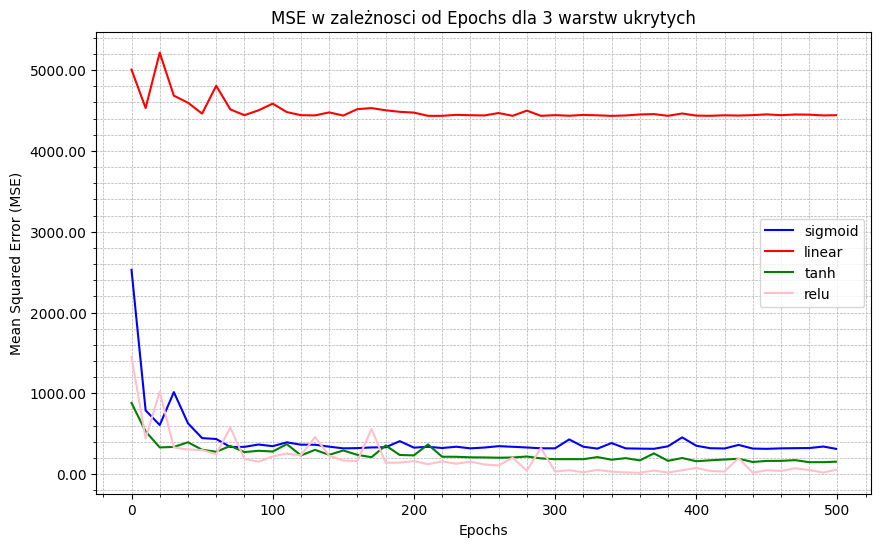

In [214]:

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_3, mse_linear_3, mse_tanh_3, mse_relu_3]
labels = ['sigmoid', 'linear', 'tanh', 'relu']
colors = ['blue', 'red', 'green', 'pink']

plot_mse(datasets, labels, colors)


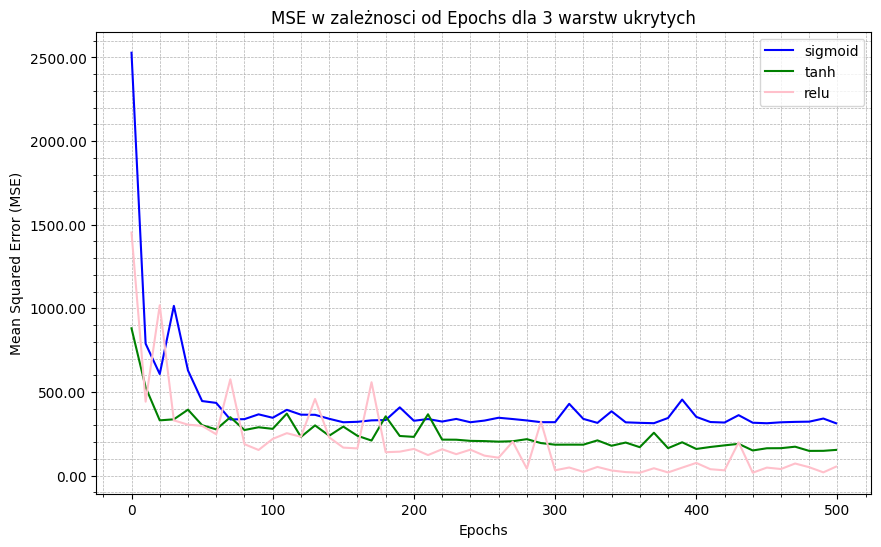

In [215]:

# Assuming mse1_01, mse50_01, mse100_01, mse200_01 are your datasets as DataFrames
datasets = [mse_sigmoid_3, mse_tanh_3, mse_relu_3]
labels = ['sigmoid',  'tanh', 'relu']
colors = ['blue', 'green', 'pink']

plot_mse(datasets, labels, colors)


#### testing

In [65]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5.propagate_forward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [67]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_multimodal_large[i])
mse_score = mse(predictions, y_test_multimodal_large)

print(f"MSE Score: {mse_score}")

predicted value:  [-97.52083727] actual value:  [-98.2081664]
predicted value:  [-54.25551153] actual value:  [-55.28389066]
predicted value:  [99.65196547] actual value:  [100.29999676]
predicted value:  [4.09228165] actual value:  [2.7206294]
predicted value:  [-73.86446255] actual value:  [-75.99163605]
predicted value:  [37.69087725] actual value:  [36.4875116]
predicted value:  [28.26103944] actual value:  [32.9071937]
predicted value:  [51.89040415] actual value:  [54.59378752]
predicted value:  [69.45158391] actual value:  [75.88595471]
predicted value:  [16.72811997] actual value:  [15.93020098]
predicted value:  [32.52955311] actual value:  [36.41048972]
predicted value:  [100.20211309] actual value:  [100.17958374]
predicted value:  [-95.59186227] actual value:  [-96.19000955]
predicted value:  [99.29064866] actual value:  [100.29859577]
predicted value:  [-63.8971626] actual value:  [-64.55778832]
predicted value:  [69.35791887] actual value:  [73.08482928]
predicted value: 

### steps-large dataset

In [222]:
scaler_X = DataScaler(method="standardization")
scaler_y = DataScaler(method="standardization")


In [223]:
# Fit and transform the training data
X_train_scaled = scaler_X.fit_transform(X_train_steps_large)
y_train_scaled = scaler_y.fit_transform(y_train_steps_large)


In [224]:
# Scale the test data using the transform method
X_test_scaled = scaler_X.transform(X_test_steps_large)
y_test_scaled = scaler_y.transform(y_test_steps_large)

In [225]:
training_data = [(x.reshape(-1, 1), y) for x, y in zip(X_train_steps_large, y_train_steps_large)]

In [227]:
training_data_scaled = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled, y_train_scaled)
]

In [ ]:
mlp_square_1_5 = MLP([1, 64, 64, 1] , activation_function=sigmoid, activation_function_derivative= sigmoid_derivative)


In [237]:
mse_sigmoid_4 = mlp_square_1_5.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 26.101175295032526
Epoch 10, MSE: 37.611566184247394
Epoch 20, MSE: 16.00604588978145
Epoch 30, MSE: 27.110306060057738
Epoch 40, MSE: 25.96029365609969
Epoch 50, MSE: 19.76261268765018
Epoch 60, MSE: 55.00641614992749
Epoch 70, MSE: 25.76579668685159
Epoch 80, MSE: 32.044326220555064
Epoch 90, MSE: 15.506982951096814
Epoch 100, MSE: 18.425890015335494
Epoch 110, MSE: 16.84666543196939
Epoch 120, MSE: 13.390431648001218
Epoch 130, MSE: 37.66685239461839
Epoch 140, MSE: 18.910302888600587
Epoch 150, MSE: 19.49749175441371
Epoch 160, MSE: 12.497990063051333
Epoch 170, MSE: 13.976758361436852
Epoch 180, MSE: 22.580073100053923
Epoch 190, MSE: 25.174541193260083
Epoch 200, MSE: 14.189546823515617
Epoch 210, MSE: 13.819899921562813
Epoch 220, MSE: 12.13360001633699
Epoch 230, MSE: 20.24862288318722
Epoch 240, MSE: 16.506130439743792
Epoch 250, MSE: 14.69654367712598
Epoch 260, MSE: 14.602450111199166
Epoch 270, MSE: 18.555336533182096
Epoch 280, MSE: 18.681953719940157
Epoch 2

In [229]:
mlp_square_1_5_relu = MLP([1, 64, 64, 1] , activation_function=relu, activation_function_derivative= relu_derivative)


[array([[-2.47808177],
       [ 0.3913471 ],
       [ 1.23039714],
       [-0.94161165],
       [-1.60300605],
       [ 2.01466108],
       [-1.6484909 ],
       [-0.7125338 ],
       [ 0.77544842],
       [-0.0800429 ],
       [-0.37982254],
       [-0.12825502],
       [-1.06197286],
       [-1.82376697],
       [-0.18749351],
       [ 0.50246521],
       [ 0.57875585],
       [-0.18302378],
       [-1.32982979],
       [-1.92658479],
       [ 0.36678838],
       [ 0.70209528],
       [ 0.3624352 ],
       [ 0.03680125],
       [ 0.79957043],
       [ 0.06426697],
       [ 1.6058441 ],
       [-1.17942902],
       [ 0.57893265],
       [ 0.14275981],
       [ 1.36438882],
       [-0.03851839],
       [-0.09161955],
       [ 0.2438322 ],
       [ 0.08427479],
       [ 0.72357033],
       [-0.02067898],
       [-0.87655582],
       [ 1.20977479],
       [ 0.25672109],
       [-0.37104636],
       [ 0.65963201],
       [-0.99334441],
       [-0.28573966],
       [ 0.05904491],
       [ 

In [238]:
mse_relu_4 = mlp_square_1_5_relu.train(
    training_data_scaled, epoch_count=500, learn_rate=0.01, batch_size_input=10,
    optimization_method='rmsprop', beta=0.9, epsilon=1e-8, 
    X_val_scaled = X_test_scaled, y_val_scaled = y_test_scaled, X_val = X_test_steps_large, y_val = y_test_steps_large, scaler_y = scaler_y,
     visual_interval = 10
)

Epoch 0, MSE: 68.81597117379204
Epoch 10, MSE: 24.967165039788245
Epoch 20, MSE: 32.4010874550281
Epoch 30, MSE: 41.855390182113375
Epoch 40, MSE: 17.74313151909342
Epoch 50, MSE: 12.155251475727896
Epoch 60, MSE: 30.006017926749525
Epoch 70, MSE: 10.256893949743402
Epoch 80, MSE: 8.74762037347951
Epoch 90, MSE: 17.2797588639406
Epoch 100, MSE: 15.772121817864917
Epoch 110, MSE: 5.973747395752039
Epoch 120, MSE: 3.3867103584504195
Epoch 130, MSE: 2.6259533129841817
Epoch 140, MSE: 8.289556616548865
Epoch 150, MSE: 8.993664455511073
Epoch 160, MSE: 6.312576389391962
Epoch 170, MSE: 10.070076725859366
Epoch 180, MSE: 2.8854221483840106
Epoch 190, MSE: 1.6850348598458862
Epoch 200, MSE: 5.07940099484029
Epoch 210, MSE: 12.68167084041603
Epoch 220, MSE: 5.539764833439767
Epoch 230, MSE: 8.586332982319997
Epoch 240, MSE: 3.4229382001179935
Epoch 250, MSE: 15.459070715335118
Epoch 260, MSE: 9.184090923106337
Epoch 270, MSE: 16.785658120439972
Epoch 280, MSE: 7.022936325323347
Epoch 290, MSE:

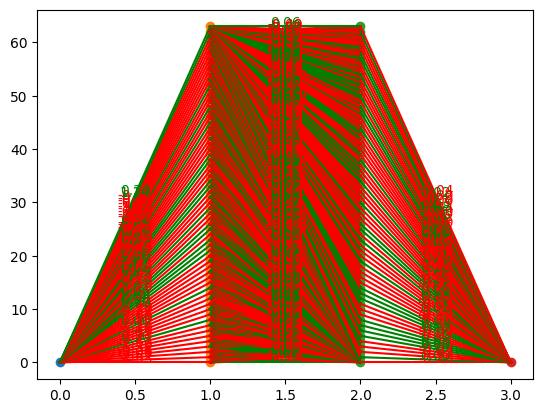

In [231]:
mlp_square_1_5_relu.visualize_network()

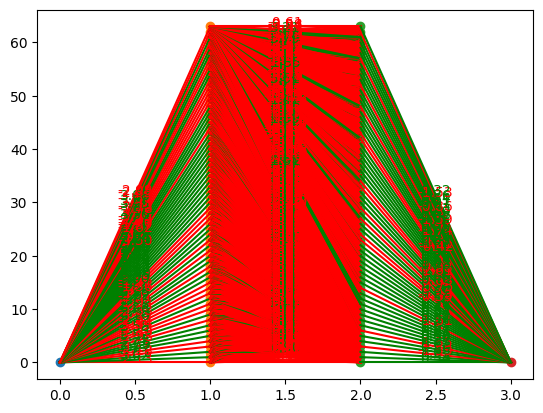

In [232]:
mlp_square_1_5.visualize_network()

#### testing

In [241]:
# Generate predictions on the scaled test data
predictions_scaled = np.array(
    [mlp_square_1_5_relu.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled]
)

In [242]:
# Correctly denormalize predictions
predictions = scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions)):
    print("predicted value: ",  predictions[i], "actual value: ", y_test_steps_large[i])
mse_score = mse(predictions, y_test_steps_large)

print(f"MSE Score: {mse_score}")

predicted value:  [162.01748281] actual value:  [160]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [81.76643903] actual value:  [80]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [81.61945336] actual value:  [80]
predicted value:  [0.17539336] actual value:  [0]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [81.47336619] actual value:  [80]
predicted value:  [162.71577993] actual value:  [160]
predicted value:  [0.36274702] actual value:  [0]
predicted value:  [0.28890845] actual value:  [0]
predicted value:  [-79.98868491] actual value:  [-80]
predicted value:  [81.49504453] actual value:  [80]
predicted value:  [162.16164375] actual value:  

In [236]:
df_test_steps_large = pd.read_csv("data/regression/steps-large-test.csv")

X_test_steps_small = df_test_steps_large["x"].values.reshape(-1, 1)
y_test_steps_small = df_test_steps_large["y"].values.reshape(-1, 1)

In [575]:
mlp_steps = MLP([1, 5, 5, 1])

[array([[ 0.22499592],
       [ 0.66393297],
       [ 0.81579735],
       [-0.93381363],
       [-1.56887485]]), array([[ 0.48408992, -0.90893581,  0.74451279,  0.26491836, -0.60762049],
       [ 0.21036234,  0.76803741,  0.00444413,  0.28424456, -0.40550138],
       [ 0.40071939, -0.39049337,  0.0533959 ,  0.28357303, -0.51281637],
       [-0.09733522,  0.20233363, -0.15237367, -0.91242117, -0.4788253 ],
       [ 0.66472232,  0.17079079,  0.40099151,  0.12026128,  0.05577142]]), array([[ 0.33198014, -0.44144792, -0.19640651, -0.21308176,  0.46809915]])]


In [576]:
# Fit and transform the training data
X_train_scaled2 = scaler_X.fit_transform(X_train_steps_small)
y_train_scaled2 = scaler_y.fit_transform(y_train_steps_small)


In [577]:
training_data_scaled2 = [
    (x.reshape(-1, 1), y) for x, y in zip(X_train_scaled2, y_train_scaled2)
]

In [578]:
mlp_steps.train(
    training_data_scaled2, epoch_count=5000, learn_rate=0.1, batch_size_input=10
)

#### testing

In [579]:
# Scale the test data using the transform method
X_test_scaled2 = scaler_X.transform(X_test_steps_small)

In [580]:
# Generate predictions on the scaled test data
predictions_scaled2 = np.array(
    [mlp_steps.feedforward(x.reshape(-1, 1))[0] for x in X_test_scaled2]
)

In [581]:
# Correctly denormalize predictions
predictions2 = scaler_y.inverse_transform(predictions_scaled2.reshape(-1, 1))

# Calculate MSE score
for i in range(len(predictions2)):
    print("predicted value: ",  predictions2[i], "actual value: ", y_test_steps_small[i])
mse_score2 = mse(predictions2, y_test_steps_small)

print(f"MSE Score: {mse_score2}")

predicted value:  [-75.68118152] actual value:  [-80]
predicted value:  [92.72419888] actual value:  [80]
predicted value:  [-88.27325684] actual value:  [-80]
predicted value:  [-70.89335599] actual value:  [-80]
predicted value:  [-78.9464397] actual value:  [-80]
predicted value:  [18.76146075] actual value:  [0]
predicted value:  [21.79168549] actual value:  [0]
predicted value:  [-87.52498457] actual value:  [-80]
predicted value:  [-74.5456806] actual value:  [-80]
predicted value:  [25.60761617] actual value:  [0]
predicted value:  [93.10415354] actual value:  [80]
predicted value:  [62.59932508] actual value:  [80]
predicted value:  [96.49685706] actual value:  [80]
predicted value:  [-75.53582894] actual value:  [-80]
predicted value:  [46.21620138] actual value:  [80]
predicted value:  [78.11865653] actual value:  [80]
predicted value:  [-18.89331856] actual value:  [0]
predicted value:  [146.8935984] actual value:  [160]
predicted value:  [-81.84228729] actual value:  [-80]
